In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

In [43]:
print(torch.__version__)

1.8.2


In [44]:
#Define File Path
vec20avg_path = "./vec_data/vec20_avg.npz"
vec25avg_path = "./vec_data/vec25_avg.npz"
vec30avg_path = "./vec_data/vec30_avg.npz"
vec35avg_path = "./vec_data/vec35_avg.npz"
vec20sum_path = "./vec_data/vec20_sum.npz"
vec20sum_path = "./vec_data/vec20_sum.npz"
vec25sum_path = "./vec_data/vec25_sum.npz"
vec30sum_path = "./vec_data/vec30_sum.npz"
vec35sum_path = "./vec_data/vec35_sum.npz"
freq_stance_labels = "./vec_data/freq_stance_labels.npz"
oh_stance_labels = "./vec_data/oh_stance_labels.npz"
le_stance_labels = "./vec_data/le_stance_labels.npz"

In [45]:
def load_npz_file(filepath):
    # Load the numpy array from the .npz file
    with np.load(filepath, allow_pickle=True) as data:
        for key in data.keys():
            arr = data[key]
            break
    return arr

In [46]:
# vec20avg = load_npz_file(vec20avg_path)
# vec25avg = load_npz_file(vec25avg_path)
vec30avg = load_npz_file(vec30avg_path)
# vec35avg = load_npz_file(vec35avg_path)
# vec20sum = load_npz_file(vec20sum_path)
# vec20sum = load_npz_file(vec20sum_path)
# vec25sum = load_npz_file(vec25sum_path)
vec30sum = load_npz_file(vec30sum_path)
# vec35sum = load_npz_file(vec35sum_path)
freq_label = load_npz_file(freq_stance_labels)
oh_label = load_npz_file(oh_stance_labels)
le_label = load_npz_file(le_stance_labels)

In [47]:
#指派實際要使用的Data與Label
# data = vec30avg
data = vec30sum
# label = np.argmax(oh_label, axis=1)
# label = oh_label
# label = freq_label
label = le_label

In [48]:
print(data.shape)
print(label.shape)
print(np.unique(label))
print(np.unique(label, return_counts=True))

(445, 1, 300)
(445,)
[0 1 2 3]
(array([0, 1, 2, 3]), array([ 11, 201,  74, 159], dtype=int64))


In [49]:
# Data Augmentation using Oversampling
# Define the oversampling ratio for each class
# oversample_ratio = {0: 100, 1: 201, 2: 120, 3: 159}
oversample_ratio = {0: 55, 1: 201, 2: 148, 3: 159}
# Initialize the oversampler
oversampler = RandomOverSampler(sampling_strategy=oversample_ratio)
# Reshape your data to a 2D matrix of shape (n_samples, n_features)
X = data.reshape(-1, 300)
# Apply oversampling to X and y
X_resampled, y_resampled = oversampler.fit_resample(X, label)
# Reshape X back to its original shape
X_resampled = X_resampled.reshape(-1, 1, 300)

In [50]:
print(X_resampled.shape)
print(X_resampled)

(563, 1, 300)
[[[-1.05289996 -1.29180002 10.12859917 ... -0.30050007  1.0638001
    0.92839986]]

 [[-0.92129999 -1.5751     10.76149985 ... -0.16209998  0.18860002
    1.30480001]]

 [[-1.47109997 -0.9589     12.55939994 ...  0.43750004  1.26569999
   -0.89280003]]

 ...

 [[-2.06100001 -1.19499998 10.82900005 ...  0.22490001 -0.7018
    0.4201    ]]

 [[-1.84299999 -1.59849997 12.11299998 ... -0.09590003  0.09940001
    0.19459999]]

 [[-1.72440002  0.09580001 11.37470001 ... -1.60950002  1.78809998
   -0.1829    ]]]


In [51]:
print(y_resampled.shape)
print(y_resampled)

(563,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 2 1 2 1 2 1 2 2 1 2 2 2 1 1 2 1 1 1 1 1 2 1 1 2 2
 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 1 2 1 1 1 1
 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2
 1 1 2 1 1 1 2 2 2 2 1 1 2 1 1 2 2 2 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 1
 2 1 2 2 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2

In [ ]:
# Create Label weights used in the Pytorch Loss Function
# Max(np.unique(label)/Label counts for every idx
# weights = [17.09, 1.0, 2.16, 1.18]
# Because My Dataset is extremely imbalanced, so we need to use weight on Loss Function.
# https://discuss.pytorch.org/t/dealing-with-imbalanced-datasets-in-pytorch/22596
# https://discuss.pytorch.org/t/what-is-the-weight-values-mean-in-torch-nn-crossentropyloss/11455/10
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [52]:
# Using original data
# train_data, test_data, train_labels, test_labels = train_test_split(data, label, test_size=0.2)
# Using oversampling data
train_data, test_data, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.3)
print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)
print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)

Train data shape: (394, 1, 300)
Train labels shape: (394,)
Test data shape: (169, 1, 300)
Test labels shape: (169,)


In [53]:
# Convert the data and labels to PyTorch tensors
train_data_tensor = torch.from_numpy(train_data).float()
train_labels_tensor = torch.from_numpy(train_labels).long()
test_data_tensor = torch.from_numpy(test_data).float()
test_labels_tensor = torch.from_numpy(test_labels).long()

In [54]:
print(train_data_tensor.shape)
print(test_data_tensor.shape)
print(train_labels_tensor.shape)
print(test_labels_tensor.shape)

torch.Size([394, 1, 300])
torch.Size([169, 1, 300])
torch.Size([394])
torch.Size([169])


In [55]:
# Create a TensorDataset for each set of data and labels
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

In [56]:
# Create a DataLoader for each dataset to batch and shuffle the data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [57]:
# Define the CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=5)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64 * 73, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        # print(x.shape) #之前為了debug忘了註解掉
        x = x.view(-1, 64 * 73)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [58]:
# Trainging Settings
num_classes = 4
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
# Define Loss Function weights
# class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=class_weights) # Using weight
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping Settings
# Define the number of epochs to wait before stopping if the test accuracy does not improve
patience = 3
# Initialize the counter for the number of epochs without improvement
counter = 0
# Initialize the best test accuracy to zero
best_val_accuracy = 0.0

# Epochs and records
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# torchmetrcis settings
model_accuracy = MulticlassAccuracy(num_classes=4).to(device)
model_precision = MulticlassPrecision(num_classes=4).to(device)
model_recall = MulticlassRecall(num_classes=4).to(device)
model_f1 = MulticlassF1Score(num_classes=4).to(device)

In [59]:
# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target.squeeze().to(torch.long))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target.squeeze().long()).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = 100.0 * train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target.squeeze().to(torch.long))
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_correct += (predicted == target.squeeze().long()).sum().item()
            model_accuracy.update(predicted, target.squeeze().long())
            model_precision.update(predicted, target.squeeze().long())
            model_recall.update(predicted, target.squeeze().long())
            model_f1.update(predicted, target.squeeze().long())
        val_loss /= len(test_loader)
        val_accuracy = 100.0 * val_correct / len(test_dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    print('Epoch: {} \tTrain Loss: {:.6f} \tTrain Accuracy: {:.2f}% \tVal Loss: {:.6f} \tVal Accuracy: {:.2f}%'.format(
          epoch, train_loss, train_accuracy, val_loss, val_accuracy))
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping at epoch", epoch)
            break

Epoch: 0 	Train Loss: 1.480577 	Train Accuracy: 35.03% 	Val Loss: 1.276453 	Val Accuracy: 26.63%
Epoch: 1 	Train Loss: 1.209560 	Train Accuracy: 36.29% 	Val Loss: 1.097754 	Val Accuracy: 60.95%
Epoch: 2 	Train Loss: 0.867436 	Train Accuracy: 69.29% 	Val Loss: 0.819324 	Val Accuracy: 64.50%
Epoch: 3 	Train Loss: 0.701390 	Train Accuracy: 73.60% 	Val Loss: 0.696301 	Val Accuracy: 69.82%
Epoch: 4 	Train Loss: 0.507198 	Train Accuracy: 79.95% 	Val Loss: 0.676455 	Val Accuracy: 68.64%
Epoch: 5 	Train Loss: 0.508446 	Train Accuracy: 80.20% 	Val Loss: 0.471245 	Val Accuracy: 81.07%
Epoch: 6 	Train Loss: 0.396599 	Train Accuracy: 83.76% 	Val Loss: 0.505017 	Val Accuracy: 78.11%
Epoch: 7 	Train Loss: 0.303929 	Train Accuracy: 89.59% 	Val Loss: 0.459765 	Val Accuracy: 79.29%
Epoch: 8 	Train Loss: 0.244642 	Train Accuracy: 92.64% 	Val Loss: 0.366308 	Val Accuracy: 84.02%
Epoch: 9 	Train Loss: 0.186754 	Train Accuracy: 94.16% 	Val Loss: 0.503410 	Val Accuracy: 80.47%
Epoch: 10 	Train Loss: 0.17169

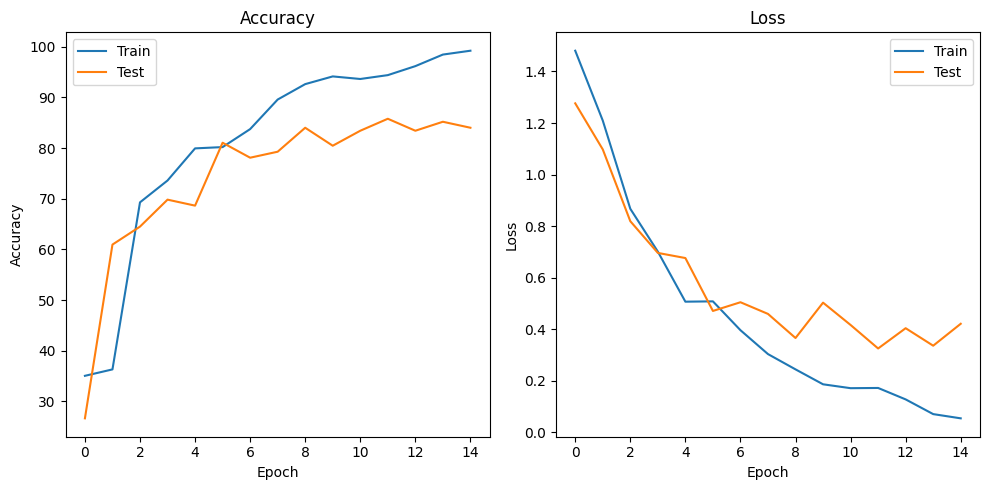

In [60]:
# Plot the train and test accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(train_accuracies, label='Train')
ax1.plot(val_accuracies, label='Test')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(train_losses, label='Train')
ax2.plot(val_losses, label='Test')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.savefig('vec30_sum_230417.PNG', dpi=300)
plt.show()

In [61]:
print('Accuracy:', model_accuracy.compute())
print('Precision:', model_precision.compute())
print('Recall:', model_recall.compute())
print('F1-score:', model_f1.compute())

Accuracy: tensor(0.7845, device='cuda:0')
Precision: tensor(0.8021, device='cuda:0')
Recall: tensor(0.7845, device='cuda:0')
F1-score: tensor(0.7817, device='cuda:0')


In [19]:
# #儲存結果好的Resample到NPZ
# save_x = {'X_resampled': np.array(X_resampled)}
# np.savez_compressed('X_resampled.npz', **save_x)
# save_y = {'y_resampled': np.array(y_resampled)}
# np.savez_compressed('y_resampled.npz', **save_y)

In [20]:
# #儲存結果好的Split Data到NPZ
# train_x = {'train_data': np.array(train_data)}
# np.savez_compressed('train_data.npz', **train_x)
# train_y = {'train_labels': np.array(train_labels)}
# np.savez_compressed('train_labels.npz', **train_y)
# test_x = {'test_data': np.array(test_data)}
# np.savez_compressed('test_data.npz', **test_x)
# test_y = {'test_labels': np.array(test_labels)}
# np.savez_compressed('test_labels.npz', **test_y)

In [ ]:
#Save Model Parameter
# torch.save(model, 'cnn_vec30sum.pt')

#### 儲存整個模型和權重
torch.save(model, './models/model.pt')   
  
#### 只儲存權重
torch.save(model.state_dict(), './models/save.pt')   
   
#### 載入整個Model
model = torch.load('./models/model.pt')   
model.eval() # 進入評估狀態    
predict = model(data[0].numpy()) # 进行预测   
   
#### 只載入權重
model = ExampleModel(input_size=6) # 必須先創建模型   
model.load_state_dict(torch.load('./models/save.pt'))   
model.eval() # 進入評估狀態    

# Calculate CNN F1-Score
https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html